### Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import gc
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve,ConfusionMatrixDisplay,accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTImageProcessor
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize, ColorJitter, RandomRotation, RandomAffine
from PIL import ImageFilter
from sklearn.metrics import classification_report
from torchvision.models import efficientnet_b7
import warnings
warnings.filterwarnings("ignore")

In [28]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


### Paths

In [29]:
model_path = 'bestModel/best_weights.pth'
train_csv = 'final_train.csv'

### Initializing resnet-50

In [30]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)

weights = torch.load(model_path, map_location=device) 

model.load_state_dict(weights)

<All keys matched successfully>

In [31]:
import torch
import torch.nn as nn
from torchvision import models, transforms

model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)  
model.to(device)

model_path = 'bestModel/best_weights.pth'
weights = torch.load(model_path, map_location=device)
model.load_state_dict(weights)


<All keys matched successfully>

In [32]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision.models import resnet50
import os

model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

dataset = datasets.ImageFolder(root='train_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model = resnet50() 
model.fc = nn.Linear(model.fc.in_features, 1) 
model.to(device)

weights = torch.load('bestModel/best_weights.pth', map_location=device)
model.load_state_dict(weights)

def extract_features_and_save_as_dataframe(dataloader, model):
    all_filenames = []  
    all_features = [] 

    with torch.no_grad():  
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device) 

            penultimate_layer = nn.Sequential(*list(model.children())[:-1]) 
            feature_batch = penultimate_layer(inputs)  

            feature_batch = feature_batch.view(feature_batch.size(0), -1)

            start_idx = batch_idx * dataloader.batch_size
            end_idx = start_idx + len(inputs)
            filenames = [os.path.splitext(os.path.basename(dataset.imgs[i][0]))[0] for i in range(start_idx, end_idx)]

            all_filenames.extend(filenames)
            all_features.extend(feature_batch.cpu().numpy())  

    df = pd.DataFrame(all_features)

    df.index = all_filenames

    df.insert(0, 'isic_id', all_filenames) 

    df.to_csv('extracted_features.csv', index=True)
    return df

df_features = extract_features_and_save_as_dataframe(dataloader, model)

In [33]:
df_csv = pd.read_csv('CSV')

In [34]:
common_columns = set(df_features.columns).intersection(set(df_csv.columns)) - {'isic_id'}


df_combined = pd.merge(df_features, df_csv, on='isic_id', how='inner')

print(df_combined['target'].value_counts())

target
0    7999
1     314
Name: count, dtype: int64


# Neural Network

In [35]:
X = df_combined.drop(columns=['target', 'isic_id']).values  

y = df_combined['target'].values

# IF CODE DOESNT COMBINE, UNCOMMENT NEXT LINES TO CHECK
# print(len(X))
# unique_values_y = np.unique(y)
# print(unique_values_y)

8313
[0 1]


In [131]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [64]:
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))


6650
1330
1663


In [88]:
# MANUAL GRID SEARCH WITH THE FOLLOWING

# [1024, 512, 256, 128, 64]
# [512, 256, 128, 64, 32],
# [2048, 1024, 512, 256, 128]
# 'dropout_rate': [0.2, 0.3, 0.4],
# 'learning_rate': [0.0001, 0.0005, 0.001]

In [146]:
import torch.nn.functional as F
class ImprovedDNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 1)

        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn5 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout(F.relu(self.bn4(self.fc4(x))))
        x = self.dropout(F.relu(self.bn5(self.fc5(x))))
        x = self.fc6(x)
        return self.sigmoid(x)


In [150]:
# 2068 features
input_dim = X.shape[1]  
model = ImprovedDNN(input_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 200

Using device: mps
Epoch [1/200], Train Loss: 0.6521, Val Loss: 0.6300
Train Accuracy: 0.6747, Train Recall: 0.6773, Train AUC: 0.6760
Val Accuracy: 0.8692, Val Recall: 0.6000, Val AUC: 0.7398
Epoch [2/200], Train Loss: 0.4257, Val Loss: 0.3797
Train Accuracy: 0.9292, Train Recall: 0.3307, Train AUC: 0.6417
Val Accuracy: 0.9316, Val Recall: 0.3800, Val AUC: 0.6666
Epoch [3/200], Train Loss: 0.3058, Val Loss: 0.2889
Train Accuracy: 0.9501, Train Recall: 0.2351, Train AUC: 0.6066
Val Accuracy: 0.9398, Val Recall: 0.4400, Val AUC: 0.6997
Epoch [4/200], Train Loss: 0.2369, Val Loss: 0.2132
Train Accuracy: 0.9585, Train Recall: 0.2271, Train AUC: 0.6071
Val Accuracy: 0.9594, Val Recall: 0.2800, Val AUC: 0.6330
Epoch [5/200], Train Loss: 0.1990, Val Loss: 0.1900
Train Accuracy: 0.9606, Train Recall: 0.1952, Train AUC: 0.5929
Val Accuracy: 0.9526, Val Recall: 0.2800, Val AUC: 0.6295
Epoch [6/200], Train Loss: 0.1742, Val Loss: 0.1463
Train Accuracy: 0.9602, Train Recall: 0.1594, Train AUC: 0.5

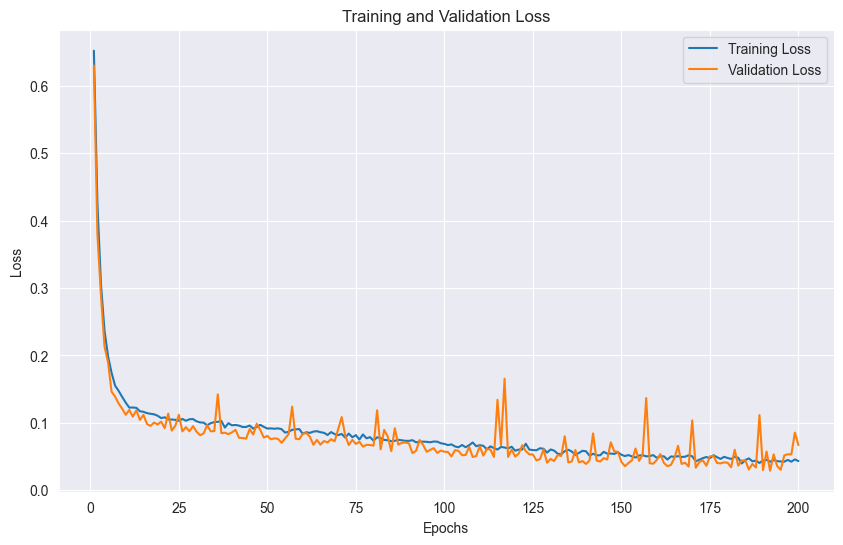

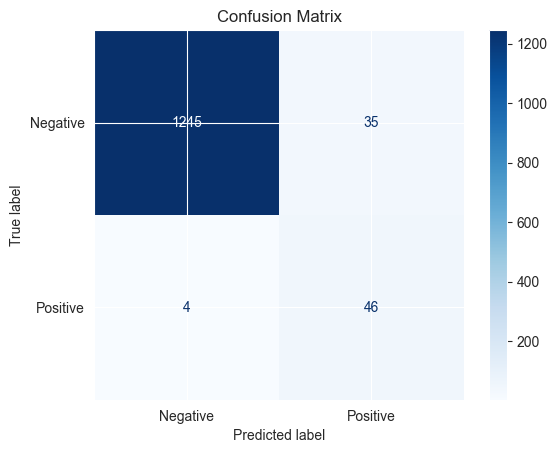

In [151]:
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_recalls = []
val_recalls = []
train_aucs = []
val_aucs = []

for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)  
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        
        # pred
        all_train_preds.extend((outputs >= 0.5).cpu().numpy())  
        # target
        all_train_targets.extend(targets.cpu().numpy())  

    train_losses.append(running_train_loss / len(train_loader))
    train_accuracy = accuracy_score(all_train_targets, all_train_preds)
    train_recall = recall_score(all_train_targets, all_train_preds)
    train_auc = roc_auc_score(all_train_targets, all_train_preds)
    train_accuracies.append(train_accuracy)
    train_recalls.append(train_recall)
    train_aucs.append(train_auc)

    model.eval()  
    running_val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():  
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device) 
            outputs = model(features).squeeze()
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            all_val_preds.extend((outputs >= 0.5).cpu().numpy())  
            all_val_targets.extend(targets.cpu().numpy())  

    val_losses.append(running_val_loss / len(val_loader))

    val_accuracy = accuracy_score(all_val_targets, all_val_preds)
    val_recall = recall_score(all_val_targets, all_val_preds)
    val_auc = roc_auc_score(all_val_targets, all_val_preds)

    val_accuracies.append(val_accuracy)
    val_recalls.append(val_recall)
    val_aucs.append(val_auc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Train Recall: {train_recalls[-1]:.4f}, Train AUC: {train_aucs[-1]:.4f}')
    print(f'Val Accuracy: {val_accuracies[-1]:.4f}, Val Recall: {val_recalls[-1]:.4f}, Val AUC: {val_aucs[-1]:.4f}')

# training and validation losses
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Val CM 
conf_matrix = confusion_matrix(all_val_targets, all_val_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# TEST 

Test Loss: 0.1781


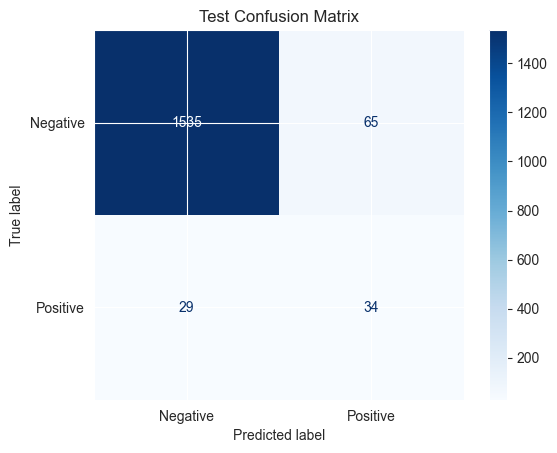

              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97      1600
    Positive       0.34      0.54      0.42        63

    accuracy                           0.94      1663
   macro avg       0.66      0.75      0.70      1663
weighted avg       0.96      0.94      0.95      1663



In [152]:
from sklearn.metrics import classification_report

model.eval()  
running_test_loss = 0.0
test_preds = []
test_targets = []

with torch.no_grad(): 
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device) 
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        running_test_loss += loss.item()

        test_preds.extend((outputs >= 0.5).cpu().numpy()) 
        test_targets.extend(targets.cpu().numpy()) 

test_loss = running_test_loss / len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

conf_matrix_test = confusion_matrix(test_targets, test_preds)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=['Negative', 'Positive'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

print(classification_report(test_targets, test_preds, target_names=['Negative', 'Positive']))